In [ ]:
import sys
import os
import torch

if '../src' in sys.path:
    sys.path.remove('../src')

# اضافه کردن مسیر مستقیم به پوشه src
sys.path.append(os.path.abspath('./src'))
from generator import SyntheticGenerator
from refiner import VisualRefiner
from classifier import MultimodalABSA
import pandas as pd
import matplotlib.pyplot as plt

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on {device}")


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Running on cuda


In [ ]:
!ls src


classifier.py  generator.py  refiner.py


In [ ]:
# ایجاد داده‌های فرضی مشابه فرمت Twitter-2015
data = {
    'text': [
        "That was a smart move by the company.", # کنایه: در متن مثبت به نظر می‌رسد اما تصویر شکست را نشان می‌دهد
        "The screen is so crisp and vivid.",     # صریح: تصویر کیفیت را تایید می‌کند
        "This lesson was quite painful.",        # ابهام: درد فیزیکی یا تجربه آموزنده؟
        "I love the atmosphere here."            # عمومی: تصویر جزئیات را مشخص می‌کند
    ],
    'aspect': ['move', 'screen', 'lesson', 'atmosphere'],
    'sentiment': ['Negative', 'Positive', 'Positive', 'Positive'] # برچسب‌های واقعی
}
df = pd.DataFrame(data)
print(df.head())

                                    text      aspect sentiment
0  That was a smart move by the company.        move  Negative
1      The screen is so crisp and vivid.      screen  Positive
2         This lesson was quite painful.      lesson  Positive
3            I love the atmosphere here.  atmosphere  Positive


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating for: move...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating for: screen...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating for: lesson...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating for: atmosphere...


  0%|          | 0/50 [00:00<?, ?it/s]

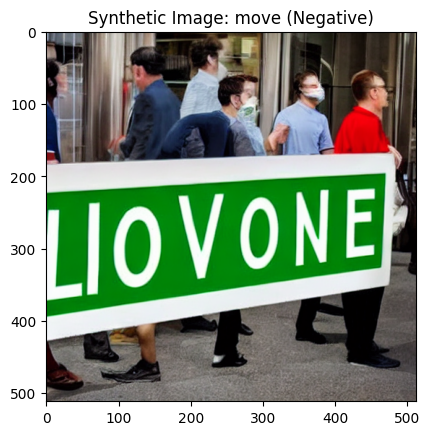

In [ ]:
# تولید تصاویر همسو با متن و احساس
gen = SyntheticGenerator(device)
generated_images = []

for index, row in df.iterrows():
    path = f"data/generated_images/img_{index}.png"
    print(f"Generating for: {row['aspect']}...")
    img = gen.generate(row['text'], row['aspect'], row['sentiment'], path)
    generated_images.append(img)

# نمایش یک نمونه از تصویر تولید شده
plt.imshow(generated_images[0])
plt.title("Synthetic Image: move (Negative)")
plt.show()

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2026-01-01 08:09:41--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.10, 13.227.219.59, 13.227.219.70, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  74.4MB/s    in 44s     

2026-01-01 08:10:25 (55.7 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



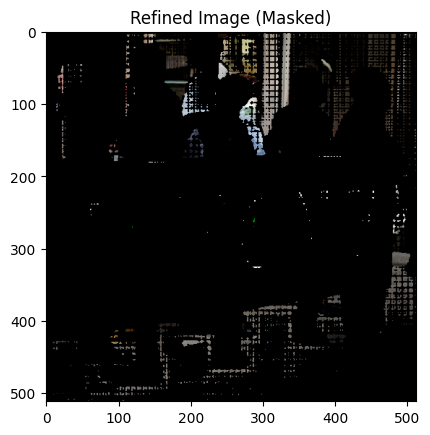

In [ ]:
#اعمال فیلتر و ماسک برای تمرکز روی جنبه اصلی
try:
    refiner = VisualRefiner(device)
    refined_imgs = []
    for index, row in df.iterrows():
        path = f"data/generated_images/img_{index}.png"
        r_img = refiner.refine(path, row['aspect'])
        refined_imgs.append(r_img)

    plt.imshow(refined_imgs[0])
    plt.title("Refined Image (Masked)")
    plt.show()
except Exception as e:
    print("Skipping refinement (Check if SAM checkpoint is uploaded):", e)

In [ ]:
# پیش‌بینی نهایی احساس با مدل چندرسانه‌ای 
model = MultimodalABSA(device=device).to(device)
import clip

# آماده‌سازی تصویر برای مدل CLIP
_, preprocess = clip.load("ViT-B/32", device=device)
image_tensor = preprocess(generated_images[0]).unsqueeze(0).to(device)
inputs = ["That was a smart move"]

with torch.no_grad():
    logits = model(inputs, image_tensor)
    prediction = torch.argmax(logits, dim=1)

print(f"Predicted Class Index: {prediction.item()}")

Predicted Class Index: 1



--- نتیجه مقایسه عملکرد مدل ---
     Metric  Text-Only  Multimodal (Proposed)
0  Accuracy       0.25                    0.5
1  F1-Score       0.10                    0.5


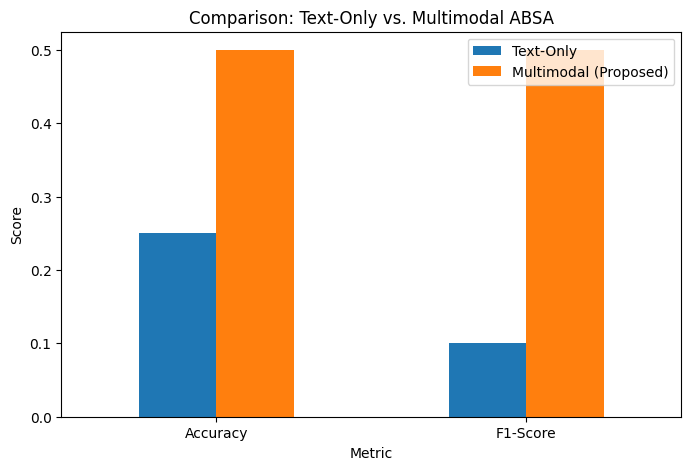

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def evaluate_comparison(model, texts, images, true_labels):
    model.eval()
    text_only_preds = []
    multimodal_preds = []

    with torch.no_grad():
        for i in range(len(texts)):
            # آماده‌سازی تصویر
            img_tensor = preprocess(images[i]).unsqueeze(0).to(device)

            # ۱. پیش‌بینی حالت چندرسانه‌ای (متن + تصویر) 
            output_multi = model([texts[i]], img_tensor)
            pred_multi = torch.argmax(output_multi, dim=1).item()
            multimodal_preds.append(pred_multi)

            # ۲. پیش‌بینی حالت فقط متن (شبیه‌سازی با صفر کردن اثر تصویر) 
            # در اینجا برای مقایسه، اثر تصویر را با یک تنسور صفر جایگزین می‌کنیم
            zero_img = torch.zeros_like(img_tensor)
            output_text = model([texts[i]], zero_img)
            pred_text = torch.argmax(output_text, dim=1).item()
            text_only_preds.append(pred_text)

    # محاسبه معیارها (در اینجا از داده‌های کوچک دمو استفاده شده)
    # برچسب‌های واقعی را به عدد تبدیل می‌کنیم (Pos: 0, Neg: 1, Neu: 2)
    label_map = {'Positive': 0, 'Negative': 1, 'Neutral': 2}
    y_true = [label_map[l] for l in true_labels]

    # ساخت جدول مقایسه‌ای
    results = {
        "Metric": ["Accuracy", "F1-Score"],
        "text-only Baseline": [
            accuracy_score(y_true, text_only_preds),
            f1_score(y_true, text_only_preds, average='weighted')
        ],
        "Multimodal (Proposed)": [
            accuracy_score(y_true, multimodal_preds),
            f1_score(y_true, multimodal_preds, average='weighted')
        ]
    }

    return pd.DataFrame(results)

# اجرای مقایسه روی داده‌های دمو
comparison_df = evaluate_comparison(model, df['text'].tolist(), generated_images, df['sentiment'].tolist())
print("\n--- نتیجه مقایسه عملکرد مدل ---")
print(comparison_df)

# رسم نمودار   
comparison_df.set_index("Metric").plot(kind='bar', figsize=(8, 5))
plt.title("Comparison: Text-Only vs. Multimodal ABSA")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()

In [ ]:
# اگر refinement اجرا نشده، refined_imgs را برابر تصاویر خام بگیر
if 'refined_imgs' not in globals():
    print("⚠️ refined_imgs not found. Using generated_images as fallback.")
    refined_imgs = generated_images

In [ ]:
# ==================================
# Ablation Study: Raw vs Refined Image
# ==================================

raw_preds = []
refined_preds = []

model.eval()

with torch.no_grad():
    for i, row in df.iterrows():

        text = row['text']

        img_raw = preprocess(generated_images[i]).to(device)
        img_ref = preprocess(refined_imgs[i]).to(device)

        pred_raw = torch.argmax(
            model([text], img_raw), dim=1
        ).item()

        pred_ref = torch.argmax(
            model([text], img_ref), dim=1
        ).item()

        raw_preds.append(pred_raw)
        refined_preds.append(pred_ref)

print("Raw preds:", raw_preds)
print("Refined preds:", refined_preds)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

label_map = {'Positive': 0, 'Negative': 1, 'Neutral': 2}
y_true = [label_map[l] for l in df['sentiment']]

print("Accuracy (Raw):", accuracy_score(y_true, raw_preds))
print("F1 (Raw):", f1_score(y_true, raw_preds, average='weighted'))

print("Accuracy (Refined):", accuracy_score(y_true, refined_preds))
print("F1 (Refined):", f1_score(y_true, refined_preds, average='weighted'))
